In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta

In [2]:
# --- Step 1: Load your real message data from CSV ---
df = pd.read_csv("/content/Simulated_Block_Detection_Data.csv")

In [4]:
print(df.columns)

Index(['sendblueNumber', 'window_end', 'messages_last_15_min',
       'errors_last_15_min', 'was_blocked'],
      dtype='object')


In [6]:
#PART 1: Analyze Rate Limits
# -------------------------------------------
print("🔍 Block Status Summary:")
rate_limit_summary = df.groupby('was_blocked').agg({
    'messages_last_15_min': ['mean', 'max'],
    'errors_last_15_min': ['mean', 'max']
}).round(2)
print(rate_limit_summary)

🔍 Block Status Summary:
            messages_last_15_min     errors_last_15_min    
                            mean max               mean max
was_blocked                                                
False                        3.7   7               0.57   3


In [8]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

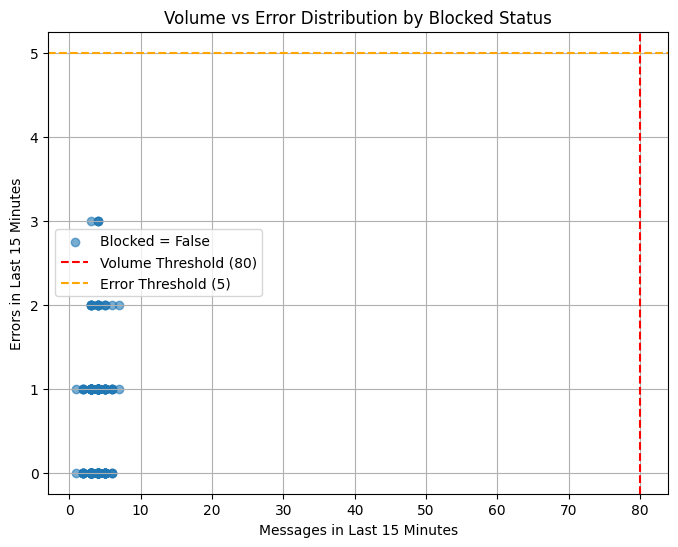

In [9]:
# Scatter plot to visualize thresholds
plt.figure(figsize=(8, 6))
for label, group in df.groupby('was_blocked'):
    plt.scatter(group['messages_last_15_min'], group['errors_last_15_min'],
                label=f'Blocked = {label}', alpha=0.6)

plt.axvline(x=80, color='red', linestyle='--', label='Volume Threshold (80)')
plt.axhline(y=5, color='orange', linestyle='--', label='Error Threshold (5)')
plt.xlabel("Messages in Last 15 Minutes")
plt.ylabel("Errors in Last 15 Minutes")
plt.title("Volume vs Error Distribution by Blocked Status")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# PART 2: Train ML Model to Predict Blocks
# -------------------------------------------
print("\n🔄 Training Model to Predict was_blocked...")

X = df[['messages_last_15_min', 'errors_last_15_min']]
y = df['was_blocked']


🔄 Training Model to Predict was_blocked...


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [13]:
print("\n📊 Classification Report (was_blocked):")
print(classification_report(y_test, y_pred))


📊 Classification Report (was_blocked):
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        40

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [14]:
# PART 3: Future-Proof ML Setup (new target: did_convert)
# -------------------------------------------
print("\n🎯 Simulating new target: did_convert (random)...")

np.random.seed(42)
df['did_convert'] = np.random.choice([True, False], size=len(df), p=[0.3, 0.7])


🎯 Simulating new target: did_convert (random)...


In [15]:
X_conv = df[['messages_last_15_min', 'errors_last_15_min']]
y_conv = df['did_convert']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_conv, y_conv, test_size=0.2, random_state=42)
model_c = RandomForestClassifier(random_state=42)
model_c.fit(X_train_c, y_train_c)
y_pred_c = model_c.predict(X_test_c)

In [16]:
print("\n📊 Classification Report (did_convert):")
print(classification_report(y_test_c, y_pred_c))


📊 Classification Report (did_convert):
              precision    recall  f1-score   support

       False       0.71      0.93      0.81        29
        True       0.00      0.00      0.00        11

    accuracy                           0.68        40
   macro avg       0.36      0.47      0.40        40
weighted avg       0.52      0.68      0.58        40



In [17]:
import seaborn as sns

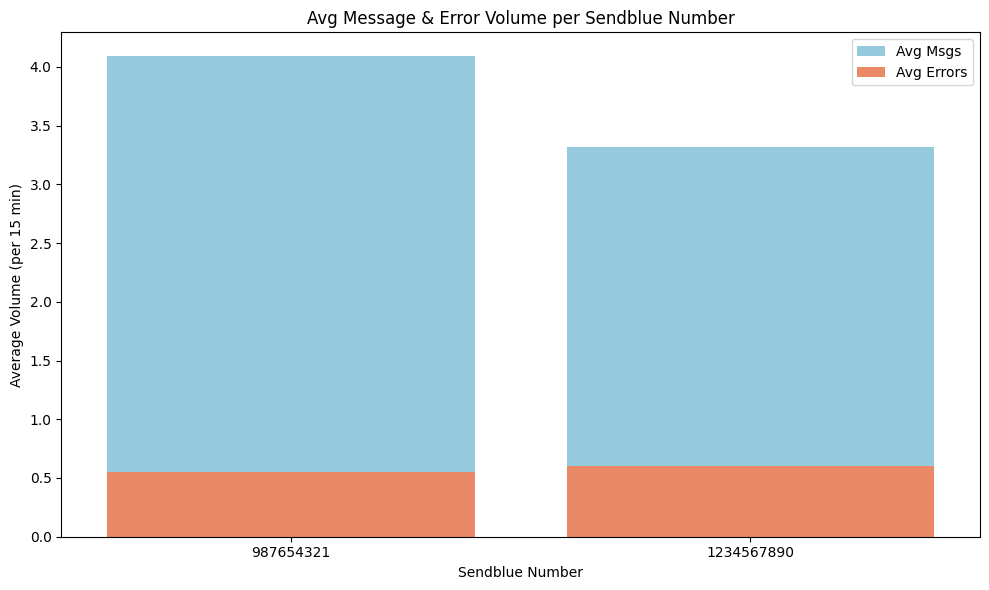

In [18]:
# 1. Bar Chart: Average Msgs & Errors per Number
# ------------------------------------------
agg_df = df.groupby('sendblueNumber').agg({
    'messages_last_15_min': 'mean',
    'errors_last_15_min': 'mean',
    'was_blocked': 'sum'
}).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=agg_df.sort_values('messages_last_15_min', ascending=False),
            x='sendblueNumber', y='messages_last_15_min', color='skyblue', label='Avg Msgs')
sns.barplot(data=agg_df.sort_values('messages_last_15_min', ascending=False),
            x='sendblueNumber', y='errors_last_15_min', color='coral', label='Avg Errors')
plt.title("Avg Message & Error Volume per Sendblue Number")
plt.ylabel("Average Volume (per 15 min)")
plt.xlabel("Sendblue Number")
plt.legend()
plt.tight_layout()
plt.show()

<ipython-input-19-25bc29f3a704>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = df.groupby(['msg_bin', 'err_bin'])['was_blocked'].mean().unstack().fillna(0)


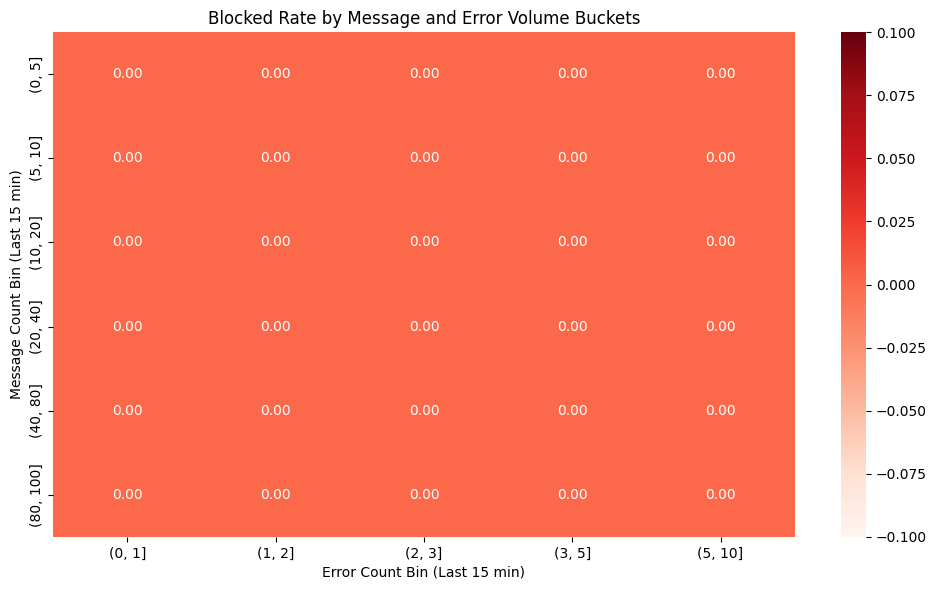

In [19]:
# 2. Heatmap: Block Rate by Message & Error Buckets
# ------------------------------------------
df['msg_bin'] = pd.cut(df['messages_last_15_min'], bins=[0, 5, 10, 20, 40, 80, 100])
df['err_bin'] = pd.cut(df['errors_last_15_min'], bins=[0, 1, 2, 3, 5, 10])

# Block rate by bin
heatmap_data = df.groupby(['msg_bin', 'err_bin'])['was_blocked'].mean().unstack().fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="Reds")
plt.title("Blocked Rate by Message and Error Volume Buckets")
plt.xlabel("Error Count Bin (Last 15 min)")
plt.ylabel("Message Count Bin (Last 15 min)")
plt.tight_layout()
plt.show()